In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2
import itertools

## JPEG-style PCA Anomaly Detection

This method of anomaly detection employs JPEG-style compression, which applies (linear) PCA feature reduction on the discrete cosine transforms of rectangular chunks of an image.

We hypothesize that anomalies can be detected when the *reconstruction loss* of a lossy compression algorithm is high. In particular, if the compression algorithm is designed to minimize loss when compressing "normal" images, we can detect the location of anomalies in a still frame by finding where the per-pixel reconstruction loss exceeds a given threshold.


In [2]:
# This is the "normal" image:
IMAGE_PATH = 'images/yellowstone.jpg'

# This is an anomolous image:
ANOMALOUS_IMAGE_PATH = 'images/yellowstone_ufo.jpg'

# This is the compression chunk size (width,height), which must
# divide the size of the image:
COMPRESSION_CHUNK_SIZE = (12,900)

# These are the number of components preserved per image chunk.
# The RGB channels are considered independent input features, so
# this quantity must be less than (width*height*3)
COMPONENTS_PER_CHUNK = 4

# This is the number of standard deviations the per-pixel loss must 
# exceed the mean by in order to be considered an anomaly:
SIGMA_K_VALUE = 3.0

### Load a Normal Image:

Shape: (900, 1200, 3)


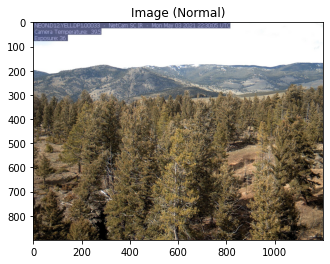

In [3]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1200, 900))

print(f'Shape: {image.shape}')
plt.imshow(image)
plt.title('Image (Normal)')
plt.show()

### Compress a Normal Image:

Compressed Image Loss: 80.92808749661809


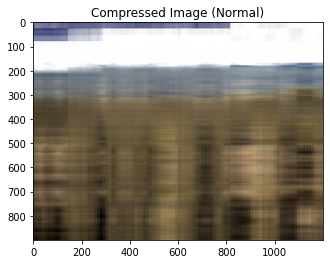

In [4]:
from sklearn.decomposition import PCA, KernelPCA
from itertools import product

def rgb_lossmap(image, approx):
    return np.sum((image - approx)**2, axis=2)

def rgb_mse(image, approx):
    assert(image.shape == approx.shape)
    area = image.shape[0] * image.shape[1]
    return np.sum((image - approx)/255)**2 / area
    
def DCT(image):
    dct_im = np.zeros(image.shape)
    for i in range(image.shape[2]):
        dct_im[:,:,i] = cv2.dct(np.float32(image[:,:,i]))
    return dct_im

def invDCT(image):
    idct_im = np.zeros(image.shape)
    for i in range(image.shape[2]):
        idct_im[:,:,i] = cv2.idct(np.float32(image[:,:,i]))
    return idct_im
    
def compressDCTPCA(image, pca, chunks=(10,10), pca_fit=False):
    sh = image.shape
    flat_image = None
    
    assert((sh[0]%chunks[1]) == 0)
    assert((sh[1]%chunks[0]) == 0)

    flat_image = np.array([
        DCT(image[i:i+chunks[1],j:j+chunks[0]]).reshape((chunks[0]*chunks[1]*sh[2],))
        for i,j in product(range(0, sh[0], chunks[1]),
                           range(0, sh[1], chunks[0]))
    ])
    
    if pca_fit:
        pca.fit(flat_image)
    trans_image = pca.transform(flat_image)
    image_comp_flat = pca.inverse_transform(trans_image)
    comp_image = np.zeros(sh)
    
    for ind, (i,j) in enumerate(product(range(0, sh[0], chunks[1]),
                           range(0, sh[1], chunks[0]))):
        comp_image[i:i+chunks[1],j:j+chunks[0],:] = \
            invDCT(image_comp_flat[ind].reshape((chunks[1],chunks[0],sh[2])))

    comp_image = np.clip(comp_image.astype(int),0,255)
    loss = rgb_mse(image, comp_image)
    
    return comp_image, loss


chunksize=COMPRESSION_CHUNK_SIZE
pca = PCA(COMPONENTS_PER_CHUNK)
comp_image, loss = compressDCTPCA(image, pca, chunks=chunksize, pca_fit=True)
print(f'Compressed Image Loss: {loss}')
plt.title('Compressed Image (Normal)')
plt.imshow(comp_image)
plt.show()


### Load and Compress an Anomalous Image:

Anomalous Compressed Image Loss: 2.141622148119647


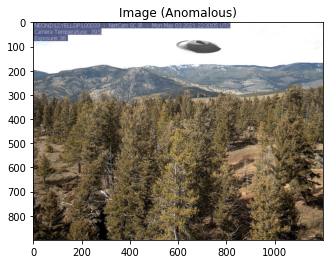

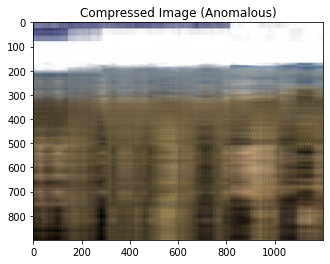

In [5]:
from sklearn import preprocessing
import matplotlib.patches as patches

image2 = cv2.imread(ANOMALOUS_IMAGE_PATH)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
image2 = cv2.resize(image2, (1200, 900))
comp_image2, loss2 = compressDCTPCA(image2, pca, chunks=chunksize)


print(f'Anomalous Compressed Image Loss: {loss2}')
plt.imshow(image2)
plt.title('Image (Anomalous)')
plt.show()

plt.imshow(comp_image2)
plt.title('Compressed Image (Anomalous)')
plt.show()

### Determine Anomaly Location:

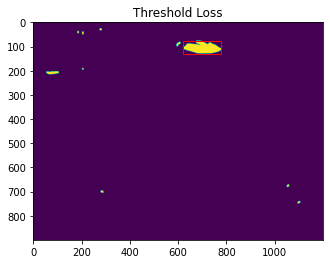

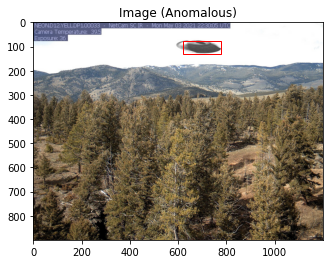

In [6]:
def identify_lossmap_boxes(lossmap, sigma_k=0.0, 
                            min_area_frac=0.0005, max_n_objs=5):
    mms = preprocessing.MinMaxScaler()
    norm_lossmap = mms.fit_transform(lossmap)
    im_size = lossmap.shape[0]*lossmap.shape[1]
    
    mean = np.mean(norm_lossmap)
    stddev = np.std(norm_lossmap)
    thresh = mean+stddev*sigma_k
    _, thresh_lossmap = cv2.threshold(norm_lossmap,thresh,1.0,cv2.THRESH_BINARY)
    thresh_lossmap = cv2.erode(thresh_lossmap, cv2.getStructuringElement(0, (4,4)))
    thresh_lossmap = cv2.dilate(thresh_lossmap, cv2.getStructuringElement(0, (7,7)))
    thresh_lossmap = cv2.normalize(thresh_lossmap, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    cnts, _ = cv2.findContours(thresh_lossmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt_list = sorted([
        (cv2.boundingRect(c),cv2.contourArea(c))
        for c in cnts ],
        key= lambda x : -x[1])
    cnts = [ ca[0] for ca in cnt_list if ca[1] > min_area_frac*im_size ]
    cnts = cnts[:min(max_n_objs, len(cnts))]
    return thresh_lossmap, cnts

def show_boxes(boxes):
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, r in enumerate(boxes):
        rect = rect = patches.Rectangle((r[0], r[1]), r[2], r[3], linewidth=1, edgecolor='r', facecolor='none')
        plt.gcf().get_axes()[0].add_patch(rect)

lossmap = rgb_lossmap(image2, comp_image2)

lm_image, lm_boxes = identify_lossmap_boxes(lossmap, SIGMA_K_VALUE)

plt.imshow(lm_image)
plt.title('Threshold Loss')
show_boxes(lm_boxes)
plt.show()

plt.imshow(image2)
show_boxes(lm_boxes)
plt.title('Image (Anomalous)')
plt.show()